## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import LSTM, Flatten

from google.colab import drive
drive.mount('/content/drive')

# To get reproducible results
from numpy.random import seed 
seed(0) 
tensorflow.random.set_seed(0)

Mounted at /content/drive


## Importing the dataset

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Biogas RMS project/Datasets/Lab dataset/reactor1_biogas.csv', 
                 index_col="day", 
                 usecols = ["day", "TS_actual", "VS_actual", "reactor1"]
                 )
df.sort_index(inplace=True)
df.head()

,TS_actual,VS_actual,reactor1
day,,,
0,369.5930,338.3879,0
1,357.2494,326.3529,100
2,344.9058,314.3179,120
3,332.5622,302.2829,100
4,320.2186,290.2479,100


## Calulating the Autocorelation

[ 1.          0.74415946  0.55784469  0.43918376  0.34675399  0.29541091
  0.26828305  0.27127423  0.29293681  0.32383909  0.29023144  0.2968465
  0.28145427  0.24019086  0.22047876  0.19603882  0.19319818  0.22652439
  0.26858631  0.29209683  0.32940691  0.35613333  0.33630124  0.34332429
  0.28739735  0.23442232  0.24624521  0.22197326  0.13976716  0.14448629
  0.12307024  0.09438243  0.10346942  0.06786983  0.07878075  0.11933073
  0.06472375 -0.00375479 -0.05780979 -0.07788187 -0.06944287]


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


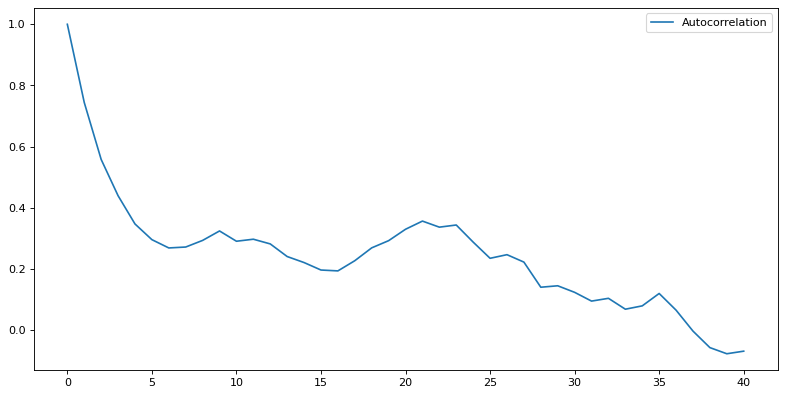

In [3]:
import statsmodels.api as sm
# Calculate the ACF of the time series
acf = sm.tsa.acf(df['reactor1'])

print(acf)
figure(figsize=(12, 6), dpi=80)
plt.plot(acf, label='Autocorrelation')
plt.legend()

## Plotting the different values
This section takes a look at the trend in the biogas values, VS and TS values.

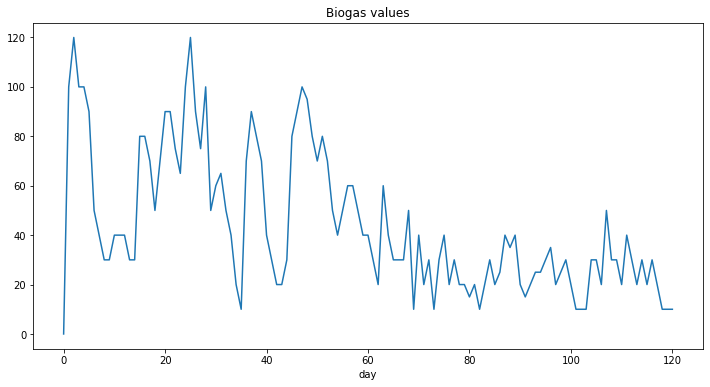

In [4]:
# Biogas values
df["reactor1"].plot(figsize=(12,6), title= "Biogas values")

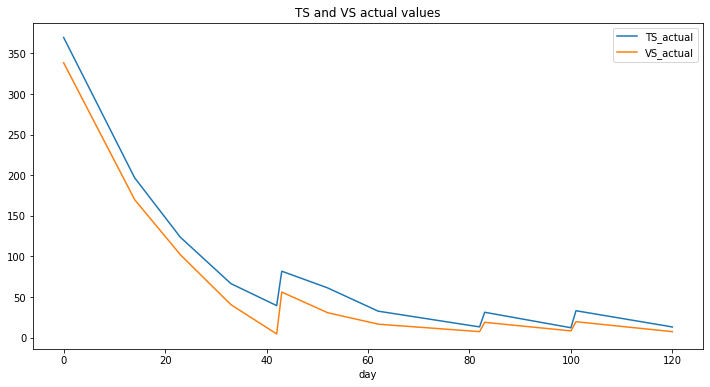

In [5]:
# VS and TS values
df[["TS_actual", "VS_actual"]].plot(figsize=(12,6), legend=True, title = "TS and VS actual values")

### Decomposing the plot
Using seasonal-decompose to find a trend, seasonal changes and noise in the plot.

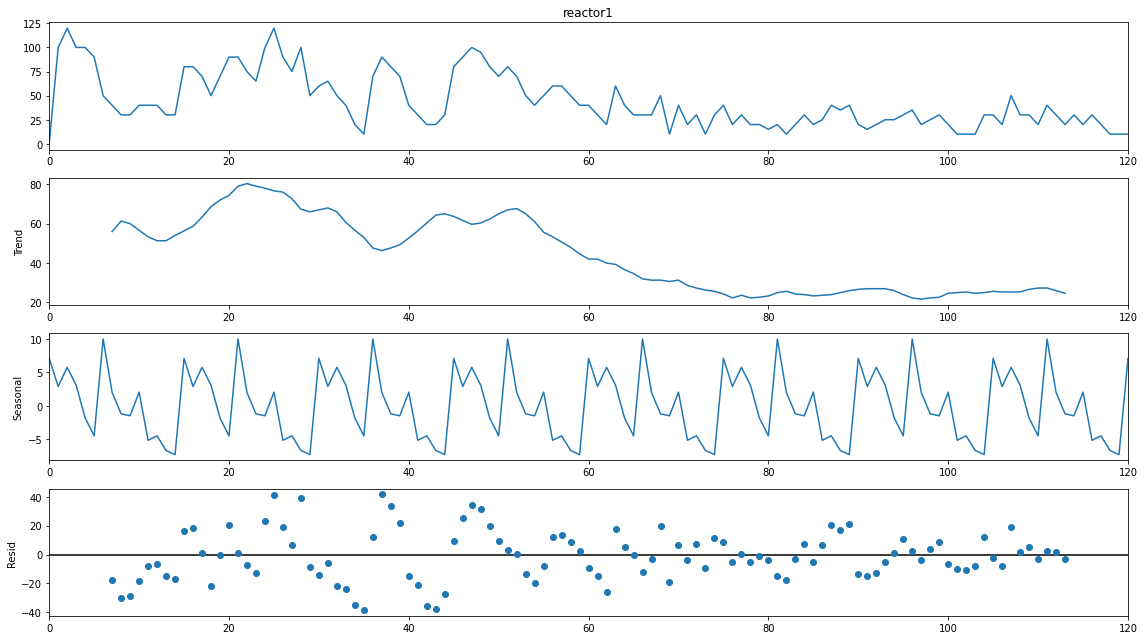

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(x= df['reactor1'],  period = 15, model='additive')
decompose_plot = results.plot();
decompose_plot.set_size_inches((16, 9))
# Tight layout to realign things
decompose_plot.tight_layout()
decompose_plot.show()

## Scaling the data
The train-test split needs to be done in a sequential manner, and not randomly.

In [7]:
# Using the MinMaxScaler
# scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(df)

scaled_dataset = scaler.transform(df)

## Generating sequences
To generate a series based input for our model.

In [8]:
def sequenceGenerator(dataset, sequenceSize=1):
  #Function that returns X and y from a given set of data points, where X is a set of sequences
    X = []
    y = []

    # using a sliding window to get values for the sequence. The value just after the sequnce is used as y
    for i in range(len(dataset)-sequenceSize-1):
        current_window = dataset[i:(i+sequenceSize), :]
        X.append(current_window)
        y.append(dataset[i+sequenceSize, -1])
        
    return np.array(X),np.array(y)

# Using the function to generate train and test sequences

# Defining the sequence size to be used.
sequence_size = 8
X, y = sequenceGenerator(scaled_dataset, sequence_size)
len(X)

112

## Splitting into train and test set
This needs to be done sequentially.

In [9]:
# Setting a fraction for train data
train_fraction = 0.7
train_size = (int)(len(X)*train_fraction)

# Splitting the train and test data
X_train = X[0:train_size]
y_train = y[0:train_size]

X_test = X[train_size :]
y_test = y[train_size :]

# Building LSTM models

## Input shape
LSTMs expect input array to be a 3D array: (batch_size, time_steps, seq_len)
* `batch_size` = Number of inputs in the training data
* `time_steps` = Number of historical datapoints being given
* `seq_len` = Number of features in a single historical datapoint

Example 1: If there are 2500 training sentences, with 50 words in each, with each word being encoded as an integer, then the input shape would be: `(2500, 50, 1)` 

So, for univariate analysis, the input shape will be:  
`(num_training_observations, sequence_size, 1)`

For multivariate analysis, the shape does not need to change.


## a) Single LSTM layer (64 neurons)

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
3/3 [==============================] - 3s 273ms/step - loss: 0.8810 - val_loss: 0.3309
Epoch 2/100
3/3 [==============================] - 0s 22ms/step - loss: 0.7002 - val_loss: 0.2163
Epoch 3/100
3/3 [==============================] - 0s 21ms/step - loss: 0.5880 - val_loss: 0.1532
Epoch 4/100
3/3 [==============================] - 0s 27ms/step - loss: 0.5557 - val_loss: 0.1233
Epoch 5/100
3/3 [==============================] - 0s 25ms/step - loss: 0.5671 - val_loss: 0.1181
Epoch 6/100
3/3 [==============================] - 0s 23ms/step - loss: 0.5653 - val_loss: 0.1180
Epoch 7/100
3/3 [==============================] - 0s 22ms/step - loss: 0.5467 - val_loss: 0.1181
Epoch 8/100


KeyboardInterrupt: ignored

### Plotting the loss

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

In [ ]:
# TRAINING DATA

# Making predictions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_train = np.repeat(predicted_train, scaled_dataset.shape[1], axis=-1)
actual_train = np.repeat(actual_train, scaled_dataset.shape[1], axis=-1)

predicted_train_inv = scaler.inverse_transform(predicted_train)[:,-1]
actual_train_inv = scaler.inverse_transform(actual_train)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
title = "TRAIN trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

In [ ]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_test = np.repeat(predicted_test, scaled_dataset.shape[1], axis=-1)
actual_test = np.repeat(actual_test, scaled_dataset.shape[1], axis=-1)

predicted_test_inv = scaler.inverse_transform(predicted_test)[:,-1]
actual_test_inv = scaler.inverse_transform(actual_test)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
title = "TEST trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

In [ ]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)[:, -1]
actual_combined_inv = scaler.inverse_transform(actual_combined)[:, -1]
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
title = "Combined trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

### Calculating the R2 score

In [ ]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score: ", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [ ]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


### Analysis
**1. Sequence size of 3, train size of 0.7**
1. Train data: There is an initial lag, which soon changes to actual trend and then to quicker than actual responding values. Trend is being followed nicely. Vey extreme changes are not completely replicated.
2. Test data: Initial lag -> actual trend -> quicker than actual. Trend is being followed to some extent. 
**Important**: values are not above the mean. Ranges are well containted within the actual ranges. Only trend and time variations are the issues.
3. r2 score:  0.713 ,  -0.259 ,  0.737
4. RMSE:  14.79 ,  10.619 ,  13.643

**2. Sequence size of 5, train size of 0.7**  
1. Train data: Similar trend (lag->actual->quicker than actual). Lag has reduced. Values are well contained, but the extreme changes are being mellowed down.
2. Test data: Values slightly greater than mean. Trend is being followed very faintly. (Worse performance than sequence_size = 3)
3. r2 score:  0.708 ,  -0.487 ,  0.718
4. RMSE:  14.457 ,  11.659 ,  13.666

**2. [BEST] Sequence size of 8, train size of 0.7** 
1. Train data: Trend is being followed with a more smoothened out curve. Small lag is present towards the end. The plot is more of a generalization of the trend than replication of the actual values
2. Test data: Values are very well contained. Extreme changes are not replicated. A very general, smooth trend is being followed.
3. r2 score:  0.775 ,  **0.209** ,  0.794
4. RMSE:  12.772 ,  8.594 ,  11.663

## b) 1 LSTM + 1 Dense layer

In [ ]:
model = Sequential()
model.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(20, activation="relu"))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

### Plotting the loss

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

In [ ]:
# TRAINING DATA

# Making predictions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_train = np.repeat(predicted_train, scaled_dataset.shape[1], axis=-1)
actual_train = np.repeat(actual_train, scaled_dataset.shape[1], axis=-1)

predicted_train_inv = scaler.inverse_transform(predicted_train)[:,-1]
actual_train_inv = scaler.inverse_transform(actual_train)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
title = "TRAIN trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

In [ ]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_test = np.repeat(predicted_test, scaled_dataset.shape[1], axis=-1)
actual_test = np.repeat(actual_test, scaled_dataset.shape[1], axis=-1)

predicted_test_inv = scaler.inverse_transform(predicted_test)[:,-1]
actual_test_inv = scaler.inverse_transform(actual_test)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
title = "TEST trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

In [ ]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)[:, -1]
actual_combined_inv = scaler.inverse_transform(actual_combined)[:, -1]
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
title = "Combined trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

### Calculating the R2 score

In [ ]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score: ", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [ ]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


### Analysis
**1. Sequence size of 3, train size of 0.7**
1. Train data: There is a initial lag, which soon changes to actual trend and then to lead. Trend is being followed. Extreme changes are not completely replicated.
2. Test data: Huge lag, trend is being followed somewhat. Value ranges are contained.
3. r2 score:  0.738 ,  -0.369 ,  0.751
4. RMSE:  14.132 ,  11.072 ,  13.266

**2.[Best shape] Sequence size of 6, train size of 0.7**
1. Train data: The curve is more smoothened out, lag has dropped very slightly.
2. Test data: Lag has reduced considerably, mainly because the curve is much more smoothened out. Trend is followed in a generalised manner.
3. r2 score:  0.721 ,  0.184 ,  0.754
4. RMSE:  14.04 ,  8.637 ,  12.629



## c) 2 LSTM layers 


In [ ]:
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(20, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

### Plotting the loss

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

In [ ]:
# TRAINING DATA

# Making predictions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_train = np.repeat(predicted_train, scaled_dataset.shape[1], axis=-1)
actual_train = np.repeat(actual_train, scaled_dataset.shape[1], axis=-1)

predicted_train_inv = scaler.inverse_transform(predicted_train)[:,-1]
actual_train_inv = scaler.inverse_transform(actual_train)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
title = "TRAIN trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

In [ ]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_test = np.repeat(predicted_test, scaled_dataset.shape[1], axis=-1)
actual_test = np.repeat(actual_test, scaled_dataset.shape[1], axis=-1)

predicted_test_inv = scaler.inverse_transform(predicted_test)[:,-1]
actual_test_inv = scaler.inverse_transform(actual_test)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
title = "TEST trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

In [ ]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)[:, -1]
actual_combined_inv = scaler.inverse_transform(actual_combined)[:, -1]
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
title = "Combined trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

### Calculating the R2 score

In [ ]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score: ", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [ ]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


### Analysis
**1. Sequence size of 8, train size of 0.7**
1. Very generalised and smooth graph. No visible lag on the train or test values.
2. Graph looks like an envelope, cover the entire spread. Extreme changes are not taken into account properly.
3. r2 score:  0.77 ,  0.063 ,  0.784
4. RMSE:  12.915 ,  9.353 ,  11.946




## d) 2 LSTM layers + 1 Dense layer


In [10]:
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),  name='LSTM1'))
model.add(LSTM(20, activation='relu', name='LSTM2'))
model.add(Dense(20, activation='relu', name='dense1'))
model.add(Dense(1, name='output'))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 8, 20)             1920      
                                                                 
 LSTM2 (LSTM)                (None, 20)                3280      
                                                                 
 dense1 (Dense)              (None, 20)                420       
                                                                 
 output (Dense)              (None, 1)                 21        
                                                                 
Total params: 5,641
Trainable params: 5,641
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
3/3 [==============================] - 5s 361ms/step - loss: 0.9592 - val_loss: 0.5833
Epoch 2/100
3/3 [==============================] - 0s 22ms/step - loss: 0.9367 - val_loss: 0.5690
Epoch 3/100
3/3 [==============================] - 0s 22ms/step - loss: 0.9217 - val_loss: 0.5590
Epoch 4/100
3/3 [==============================] - 0s 22ms/step - loss: 0.9094 - val_loss: 0.5490
Epoch 5/100
3/3 [==============================] - 0s 23ms/step - loss: 0.8950 - val_loss: 0.5393
Epoch 6/100
3/3 [==============================] - 0s 22ms/step - loss: 0.8824 - val_loss: 0.5274
Epoch 7/100
3/3 [==============================] - 0s 23ms/step - loss: 0.8699 - val_loss: 0.5143
Epoch 8/100
3/3 [==============================] - 0s 21ms/step - loss: 0.8546 - val_loss: 0.4987
Epoch 9/100
3/3 [==============================] - 0s 30ms/step - loss: 0.8376 - val_loss: 0.4787
Epoch 10/100
3/3 [==============================] - 0s 21ms/step - loss: 0.8169 - val_loss: 0.4560
Epoch 11/100
3/3 [

### Plotting the loss

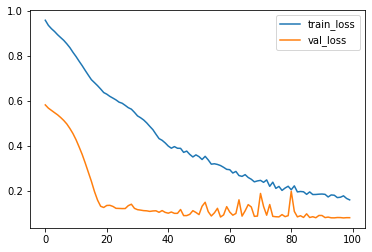

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 1s 6ms/step


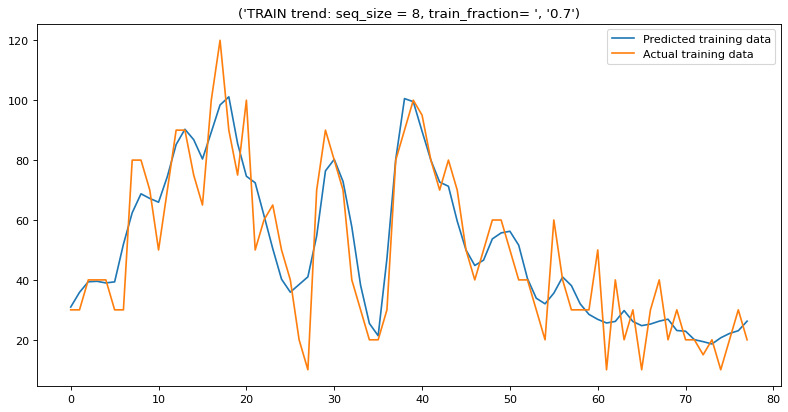

In [13]:
# TRAINING DATA

# Making predictions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_train = np.repeat(predicted_train, scaled_dataset.shape[1], axis=-1)
actual_train = np.repeat(actual_train, scaled_dataset.shape[1], axis=-1)

predicted_train_inv = scaler.inverse_transform(predicted_train)[:,-1]
actual_train_inv = scaler.inverse_transform(actual_train)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
title = "TRAIN trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

2/2 [==============================] - 0s 7ms/step


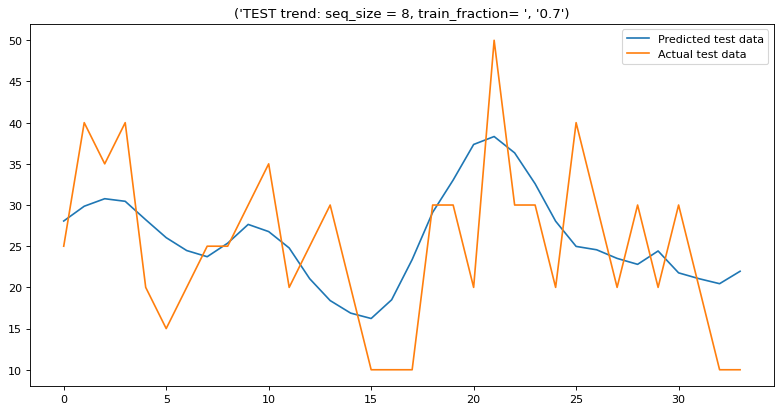

In [14]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_test = np.repeat(predicted_test, scaled_dataset.shape[1], axis=-1)
actual_test = np.repeat(actual_test, scaled_dataset.shape[1], axis=-1)

predicted_test_inv = scaler.inverse_transform(predicted_test)[:,-1]
actual_test_inv = scaler.inverse_transform(actual_test)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
title = "TEST trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

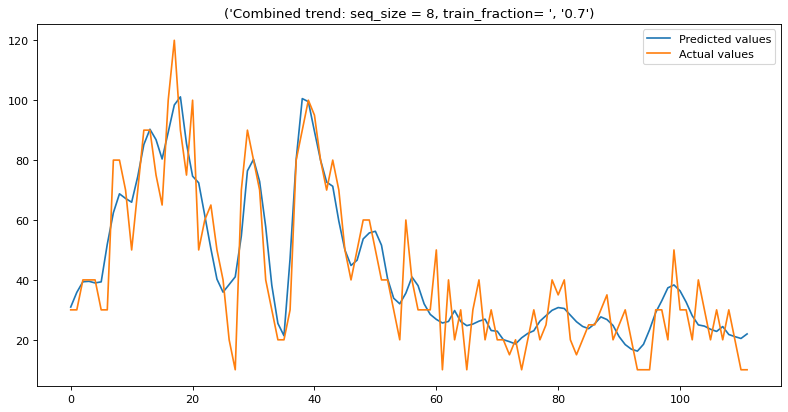

In [15]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)[:, -1]
actual_combined_inv = scaler.inverse_transform(actual_combined)[:, -1]
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
title = "Combined trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

### Calculating the R2 score

In [16]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score: ", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

r2 score:  0.828 ,  0.308 ,  0.839


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [17]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


RMSE:  11.16 ,  8.039 ,  10.313


In [18]:
import numpy as np
from sklearn.metrics import mean_absolute_error

def mean_directional_accuracy(predicted: np.ndarray, actual: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - actual[:-1])).astype(int))


predicted_combined = predicted_combined[:,0]
predicted_train = predicted_train[:, 0]
predicted_test = predicted_test[:, 0]

actual_combined = actual_combined[:, 0]
actual_train = actual_train[:, 0]
actual_test = actual_test[:, 0]
mda = mean_directional_accuracy(predicted_train, actual_train)
print(mda)

mda = mean_directional_accuracy(predicted_test, actual_test)
print(mda)

mda = mean_directional_accuracy(predicted_combined, actual_combined)
print(mda)


0.7142857142857143
0.6363636363636364
0.6936936936936937


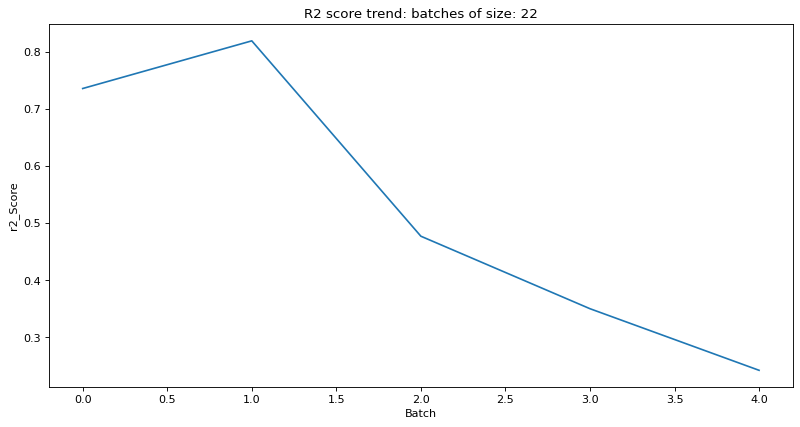

In [63]:
# Calculate the variance as a function of time

r2_scores = []
step = 22
for i in range(1,111, step):
  y_true = []
  y_pred = []
  for j in range(i, i+step-1):
    if j>=112:
      break
    y_true.append(actual_combined[j])
    y_pred.append(predicted_combined[j])

  # r2_curr = sqrt(mean_squared_error(y_true, y_pred))
  r2_curr = r2_score(y_true, y_pred)
  r2_scores.append(r2_curr)

# Plot the variance as a function of time

figure(figsize=(12, 6), dpi=80)
title = "R2 score trend: batches of size: "+ str(step) 
plt.title(title)
plt.plot(r2_scores)
plt.xlabel('Batch')
plt.ylabel('r2_Score')
plt.show()



### Analysis
**1. [BEST r2 overall] Sequence size of 8, train size of 0.7**
1. Generalised and smooth. Values in the test set are close to the mean, trend is followed in a general manner.
3. r2 score:  0.828 ,  0.308 ,  0.839
4. RMSE:  11.16 ,  8.039 ,  10.313




In [20]:
import json
model.save("model")